# Anomaly Detection

The objective of this notebook is to identify atypical observations in the dataset
without relying on the target variable.

### Data loading and scope definition


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from pathlib import Path

DATA_PATH = Path("../data")

primary = pd.read_csv(DATA_PATH/"primary_cohort_clean.csv")
study = pd.read_csv(DATA_PATH/"study_cohort_clean.csv")
validation = pd.read_csv(DATA_PATH/"validation_cohort_clean.csv")
df = pd.concat([primary, study, validation], ignore_index=True)



I concatenate the three cohorts to explore anomalies at a global level.
The detected anomalies are therefore interpreted as global atypical profiles,
not cohort-specific deviations.

### Feature selection

In [3]:
features = [
    'age_years',
    'episode_number'
]

X = df[features]

I restrict anomaly detection to a small set of interpretable variables.

- `age_years` is continuous and clinically meaningful.
- `episode_number` captures repeated hospitalizations and may reveal unusual care trajectories.

### Scaling

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Scaling is required for distance-based and tree-based anomaly detection methods
to prevent variables with larger ranges from dominating the model.

### Isolation Forest implementation

In [5]:
#Hyperparameter tuning
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    max_samples= 'auto',
    max_features=1.0,
    random_state=42,
    n_jobs=-1
)

df['anomaly'] = iso_forest.fit_predict(X_scaled)
df['anomaly'].value_counts()

anomaly
 1    2671
-1     134
Name: count, dtype: int64

Isolation Forest is used as a non-parametric, unsupervised method.
The contamination parameter is set conservatively and later evaluated for stability.

## Hyperparameters stability analysis

In [6]:
from itertools import combinations
param_grid = [
    {"contamination": 0.02, "max_samples": 128, "n_estimators": 200},
    {"contamination": 0.02, "max_samples": 256, "n_estimators": 200},
    {"contamination": 0.05, "max_samples": 128, "n_estimators": 200},
    {"contamination": 0.05, "max_samples": 256, "n_estimators": 200},
    {"contamination": 0.08, "max_samples": 256, "n_estimators": 300},
]

results= {}

# line comparaison
for params in param_grid:
    iso = IsolationForest(random_state=42, **params)
    labels = iso.fit_predict(X_scaled)
    results[str(params)] = set(df.index[labels == -1])
    #print(f"contamination={params} → number of anomalies={(labels == -1).sum()}")


In [8]:
# measure stability
for (p1, a1), (p2, a2) in combinations(results.items(), 2):
    jaccard = len(a1 & a2) / len(a1 | a2)
    print(f"{p1} vs {p2} → Jaccard = {jaccard:.2f}")

{'contamination': 0.02, 'max_samples': 128, 'n_estimators': 200} vs {'contamination': 0.02, 'max_samples': 256, 'n_estimators': 200} → Jaccard = 0.66
{'contamination': 0.02, 'max_samples': 128, 'n_estimators': 200} vs {'contamination': 0.05, 'max_samples': 128, 'n_estimators': 200} → Jaccard = 0.37
{'contamination': 0.02, 'max_samples': 128, 'n_estimators': 200} vs {'contamination': 0.05, 'max_samples': 256, 'n_estimators': 200} → Jaccard = 0.36
{'contamination': 0.02, 'max_samples': 128, 'n_estimators': 200} vs {'contamination': 0.08, 'max_samples': 256, 'n_estimators': 300} → Jaccard = 0.23
{'contamination': 0.02, 'max_samples': 256, 'n_estimators': 200} vs {'contamination': 0.05, 'max_samples': 128, 'n_estimators': 200} → Jaccard = 0.28
{'contamination': 0.02, 'max_samples': 256, 'n_estimators': 200} vs {'contamination': 0.05, 'max_samples': 256, 'n_estimators': 200} → Jaccard = 0.39
{'contamination': 0.02, 'max_samples': 256, 'n_estimators': 200} vs {'contamination': 0.08, 'max_sam

Rather than selecting hyperparameters based solely on the number of detected anomalies,
I evaluate the stability of anomaly sets using the Jaccard similarity.

High similarity suggests structural anomalies,
while low similarity indicates sensitivity to parameter choice.


## Visualisation of detected anomalies


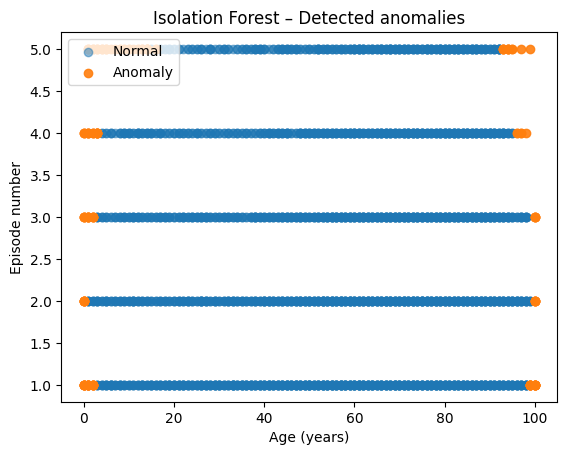

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    df.loc[df["anomaly"] == 1, "age_years"],
    df.loc[df["anomaly"] == 1, "episode_number"],
    alpha=0.5,
    label="Normal"
)

plt.scatter(
    df.loc[df["anomaly"] == -1, "age_years"],
    df.loc[df["anomaly"] == -1, "episode_number"],
    alpha=0.9,
    label="Anomaly"
)

plt.xlabel("Age (years)")
plt.ylabel("Episode number")
plt.title("Isolation Forest – Detected anomalies")
plt.legend()
plt.show()


The plot may therefore exaggerate separation effects
and should not be interpreted as a strict decision boundary.

### anomaly score analysis

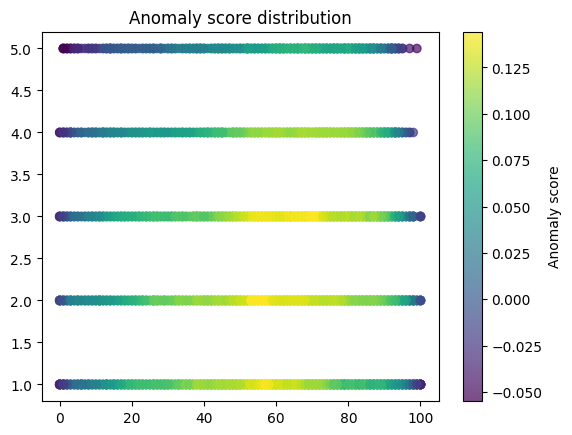

In [10]:
df['score'] = iso_forest.decision_function(X_scaled)

df['score'].describe()
df.loc[df['score'] < 0].head()


plt.scatter(
    df['age_years'],
    df['episode_number'],
    c=df['score'],
    alpha=0.7
)
plt.colorbar(label="Anomaly score")
plt.title("Anomaly score distribution")
plt.show()





The anomaly score provides a continuous measure of abnormality.
Lower values correspond to more isolated observations.
This allows flexible thresholding and avoids binary decisions at this stage.


## Statistical outlier diagnostics
### Z-score with only age


In [11]:
from scipy.stats import zscore

age_z = zscore(df["age_years"])
z_outliers = np.abs(age_z) > 3
z_outliers.sum()


np.int64(0)

Z-score is applied only to continuous variables.
It highlights extreme values but does not account for multivariate context.

### IQR with age

In [12]:
Q1 = df["age_years"].quantile(0.25)
Q3 = df["age_years"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

iqr_outliers = (df["age_years"] < lower) | (df["age_years"] > upper)
iqr_outliers.sum()

np.int64(0)

IQR-based detection is robust and complements Z-score diagnostics.

----

At this stage, I deliberately avoid removing observations.

In a clinical dataset, extreme values may correspond to rare but valid patients.
Removing them would risk introducing bias and reducing model generalization.

For later modeling stages, winsorization is preferred over deletion.
Thresholds will be learned on the training set only and applied consistently to the test set.

### Conclusion

This anomaly detection phase provides complementary perspectives:
- multivariate anomalies using Isolation Forest,
- univariate extremes using statistical diagnostics.

Rather than enforcing hard decisions, these analyses guide
subsequent data cleaning and feature engineering steps.
